<b>Arnie Larson<br>
EEP 592 - Radar, Autumn 2022<br>
HW2<br>
10/20/2022</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy.io import wavfile


<b>1)<br></b>

For a radar system with average time between false alarms $T_{fa}=30min$ and receiver bandwidth $B=0.4MHz$

Probability of false alarm $P_{fa} = e^{(\frac{-V_{th}^2}{2N_0})}$

Average time betwee false alarms $T_{fa} = \frac{1}{B} e^{(\frac{V_{th}^2}{2N_0})}$

(a) 30 minute probability $P_{fa} \approx 1.3 \times 10^{-9}$<br>
(b) 30 minute FA average threshold to noise power ration $V_T^2/N_0 \approx 40$<br>
(c) 1 year probability $P_{fa} \approx 7.9 \times 10^{-14}$<br>
    1 year FA average threshold to noise power ration $V_T^2/N_0 \approx 60$<br>
(d) 30min $T_{fa}$ threshold is lowered by 0.3 dB $T_{fa} \rightarrow 7.7 min $<br>
(e) 30min $T_{fa}$ threshold is increased by 0.3 dB $T_{fa} \rightarrow 129 min$<br>
(f) Can not likley tune a system to a precise "false alarm time"; system design likley will have another target parameter 

In [2]:
# 0.3db factors: 
p3db=10**(0.3/10); mp3db=10**(-.3/10)
print (".3db:  {}".format(p3db))
print ("-.3db: {}".format(mp3db))

.3db:  1.0715193052376064
-.3db: 0.933254300796991


In [3]:
T_30 = 30 * 60; B = 0.4e6 # 0.4MHz bandwidth
T_yr = 8760*60*60
VN_ratio_30m = 2* np.log(T_30*B)
VN_ratio_yr = 2* np.log(T_yr*B)
Pfa_30m = np.exp(VN_ratio_30m*-0.5)
Pfa_yr = np.exp(VN_ratio_yr*-0.5)
print("T_30min, Probability: {}; threshold to noise power ratio: {}".format(Pfa_30m, VN_ratio_30m))
print("T_1year, Probability: {}; threshold to noise power ratio: {}".format(Pfa_yr, VN_ratio_yr))
print("T_30min -.3db, T_fa: {} min".format(np.exp(mp3db*VN_ratio_30m*0.5)/B/60))
print("T_30min +.3db, T_fa: {} min".format(np.exp(p3db*VN_ratio_30m*0.5)/B/60))

T_30min, Probability: 1.3888888888888867e-09; threshold to noise power ratio: 40.78952353994875
T_1year, Probability: 7.927447995941144e-14; threshold to noise power ratio: 60.331720268929516
T_30min -.3db, T_fa: 7.690107381824708 min
T_30min +.3db, T_fa: 129.0005378763669 min


<b>2 )</b><br>

A radar non coherently integrates 18 received pulses<br>

$P_{d} = 0.8$

$T_{fa} = 20 min$

$B = 100kHz$

What is $P_{fa}$?  Can I calculate it using the equations in the notes?  I believe so - however, the SNR will be that of the integration rather than that of a single pulse

Then in Richards p 373, eq) 6.87 ( The Albersheim's eqns) it shows how to estimate SNR (or SIR) for non coherently integrated pulses.

(a) Calculating $P_{fa}$ as above and then use Albersheim equations from Richards:<br>
$P_{fa} \approx 8.3 \times 10^{-9}$<br>
$SNR \approx 3.67 dB$

(b) To approximate the same system with a single pulse:  You'd need approximately 13.7 dB SNR

This is consistent with figure 6.11 in Richards

(c) Not completed yet



In [4]:
T_fa=20*60; B_2=100e3; P_d=0.8
P_fa= np.exp(-1*np.log(T_fa*B_2))
print("P_fa = {}".format(P_fa))

P_fa = 8.333333333333347e-09


In [5]:
# Albersheim, non coherent integration of N = 18 pulses
A = np.log(0.62/P_fa); B=np.log(P_d/(1-P_d)); N=18
SIR18=-5*np.log10(N) + (6.2+(4.54/np.sqrt(N+0.44)))*np.log10(A + 0.12*A*B + 1.7*B)
N=1
# equivalent system with a single pulse
SIR1=-5*np.log10(N) + (6.2+(4.54/np.sqrt(N+0.44)))*np.log10(A + 0.12*A*B + 1.7*B)
print("SIR18: {} dB".format(SIR18))
print("SIR1: {} dB".format(SIR1))

SIR18: 3.6733897537544085 dB
SIR1: 13.687246574391986 dB


<b>3 )</b><br>

Model the doppler signal for a low power radar module as spec'd, with 2 moving targets and using program code from HW 1, add<br>
- Add the effects of a 20dB and 90dB Gaussian noise channel, plot spectrogram and generate WAV files
- Add the effect of a Swerling 1 type model on the target RCS, plot spectrogram and generate WAV file

Kinematics for the bicycle and car (moving away from module):<br>
$x_0=1m$; $v(t) = v_0 + a_0 t$; $x(t) = x_0 + v_0 t + \frac{1}{2}a_0 t^2$<br>
Bicycle:<br>
$v_0 = 4.5 m/s$; $a_0 = 0.1 m/s^2$<br>
Car:<br>
$v_0 = 26.8 m/s$; $a_0 = 0.5 m/s^2$<br><br>

Model the Signal: (Note signal Amplitude should go as square root of power received $S_r$)<br>
$y(t) = A( \vec{x}, \sigma) cos(\omega(\vec{v}) t + \phi)$<br>
$y(t) \simeq \sqrt{S_r}$

Noise (AGWN):
$n(t) \sim \frac{1}{\sqrt{2\pi\sigma^2}}exp^{\frac{-(x- \mu)^2}{2\sigma^2}}$;  with $N_0 = \sigma^2$; and $90 dB \rightarrow N_0 = 20^{-90/20} A_{max}$

Swirling 1 Model:<br>
Cross section changes from scan to can (but not within scan)<br>
$P(\sigma) = \frac{1}{\bar{\sigma}} e^{(\frac{\sigma}{\bar{\sigma}})}$


<b>Updates:</b><br>
- The objects move out of the range of the radar module quickly, but after changes to signal routine to plot signal amplitude, the signal is visible for much longer.
- The wav file still mostly sounds like a "ping" but the slow increase in frequency "chirp" of the bicycle is audible
- AWGN has interesting effects on Spectrogram (and audio output)


In [6]:
print(10**(9/10))
print(10*np.log10(9))

7.943282347242816
9.542425094393248


In [7]:
# radar range as function of sigma target:
# Gain 9dBi = 8, Transmit Pt=10mW = 10e-3 W, Receiver Pr = -60dBm = 10^-6 mW  = 1e-9 W
c=3e8; fcw=10.5e9; Gcw=10**(9.0/10); Prcw=1e-9; Ptcw=10e-3; lmbda_cw=c/fcw 
Aecw=Gcw*lmbda_cw**2/(4*np.pi)
sigmacw=np.logspace(-2, 2)  ## log space from .01 to 100 (50 steps default)
# Radar max range for CW module:
Rcw=(Ptcw*Gcw*Aecw*sigmacw/((4*np.pi)**2 * Prcw))**(0.25)

In [8]:
print("d**-2: {} vs d**-1/2: {}".format(np.power(2.0, -2), np.power(2, -0.5)))

d**-2: 0.25 vs d**-1/2: 0.7071067811865476


In [9]:
# Generate radar signal, will use functions to get signal amplitude and frequency

# get signal strength (cs: cross_section, d: distance)
# Signal will be proportional to sqrt of received power
def get_sig(cs, d):
    sig = np.sqrt(Ptcw*Gcw*Aecw*cs/((4*np.pi)**2*d**4))
    return sig

# max signal (cs = 100, d = 1)
Pr_max = get_sig(100, 1)+get_sig(2, 1)
print("Pr_max (car): {:.7f}".format(Pr_max))

   
# get signal frequency ( v: velocity, ftx: radar frequency)
def get_doppler(v, ftx=10.5e9):
    return 2*v*ftx/c

# normalize signal to int16 for using .wav files
def get_norm(S, norm=32767):
    s=norm*S/S.max()
    return s.astype(np.int16)

## Testing functions
print("Car signal at 1m: {:.3f}".format(get_sig(100,1)))
print("Car signal at 5m: {:.3f}".format(get_sig(100,5)))
print("Car signal at 10m: {:.3f}".format(get_sig(100,10)))
print("Car signal at 15m: {:.3f}".format(get_sig(100,15)))
print("Car signal at 100m: {:.3f}".format(get_sig(100,100)))
print("Bicycle signal at 1m: {:.3f}".format(get_sig(2,1)))
print("Bicycle signal at 10m: {:.3f}".format(get_sig(2,10)))
print("IF Freq at 1m/s: {:.3f}".format(get_doppler(1)))
print("IF Freq at 5m/s: {:.3f}".format(get_doppler(5)))
print("IF Freq at 25m/s: {:.3f}".format(get_doppler(25)))
    
    

Pr_max (car): 0.0058152
Car signal at 1m: 0.005
Car signal at 5m: 0.000
Car signal at 10m: 0.000
Car signal at 15m: 0.000
Car signal at 100m: 0.000
Bicycle signal at 1m: 0.001
Bicycle signal at 10m: 0.000
IF Freq at 1m/s: 70.000
IF Freq at 5m/s: 350.000
IF Freq at 25m/s: 1750.000


max S: 0.005815179885573081; min S: -0.005307973284546236


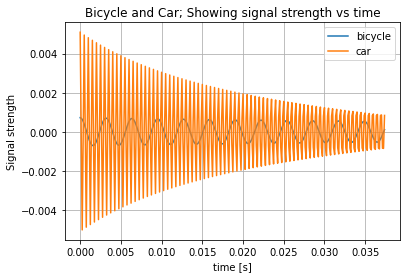

In [10]:
## Generate IF signals for moving car and bicylce
## Signal written to file: S.test.wav at 8kHz sample rate

t_max=15; f_sample=8000
t=np.linspace(0,t_max,num=f_sample*t_max)

# Signal 1 is bicycle (cs=2); Signal 2 is car (cs=100)
x0b=1; v0b=4.5; a0b=0.1
xb=x0b+v0b*t+0.5*a0b*t**2
vb=v0b+a0b*t
Ab=np.array([get_sig(2, x) for x in xb])
fb=np.array([get_doppler(v) for v in vb])
Sb=(Ab*np.cos(2*np.pi*fb*t))

# Signal 2 is a car
x0c=1; v0c=28.6; a0c=0.5
vc=v0c+a0c*t
xc=x0c+v0c*t+0.5*a0c*t**2

# Calculate amplitude and frequency of signal vs time
Ac=np.array([get_sig(100, x) for x in xc])
fc=np.array([get_doppler(v) for v in vc])
Sc=(Ac*np.cos(2*np.pi*fc*t))

# This is the full signal
S=Sb+Sc
## wavfile.write("S.test.wav", f_sample, S)

print("max S: {}; min S: {}".format(S.max(), S.min()))
# Plot of the initial separated signals 
plt.plot(t[:300], Sb[:300], label='bicycle')
plt.plot(t[:300], Sc[:300], label='car' )
plt.xlabel("time [s]"), plt.ylabel("Signal strength")
plt.legend(loc='upper right'); plt.grid(True)
plt.title("Bicycle and Car; Showing signal strength vs time")
plt.show()

In [27]:
t[-1]

15.0

<b>a)</b> Generate signal and spectrograms with addition of 90dB and 20dB Noise Power (relative to maximum signal)<br>
<b>b)</b> Write signals as .WAV files

In [11]:
## Noise -90db relative to full scale  (Sigma^2 is Noise Power )
N_90 = S.max() * 10**(-90/20)
N_20 = S.max() * 10**(-1)
print("Max Signal: {};   Noise Variance 90dB: {}; 20dB: {}".format(S.max(), N_90, N_20))

Max Signal: 0.005815179885573081;   Noise Variance 90dB: 1.8389213442008268e-07; 20dB: 0.0005815179885573081


In [12]:
rng = np.random.default_rng()  # random number generator
n90 = rng.normal(0, N_90, t_max*f_sample)
n20 = rng.normal(0, N_20, t_max*f_sample)

In [14]:
## Read and write the data from the wavfile and plot spectrograms
S90 = get_norm(S+n90)
S20 = get_norm(S+n20)
wavfile.write("S.wav", f_sample, get_norm(S))
wavfile.write("S.90db.wav", f_sample, S90)
wavfile.write("S.20db.wav", f_sample, S20)


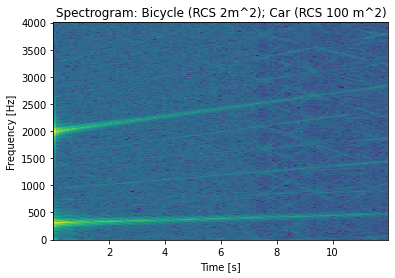

In [28]:
## Plot spectrogram (First 12 seconds, no noise)
f, ts, Sx = signal.spectrogram(get_norm(S)[:12*f_sample], f_sample, nperseg=256*4) #, nfft=256*2)
plt.pcolormesh(ts, f, Sx, shading="auto", norm=colors.LogNorm(vmin=Sx.min(), vmax=Sx.max()))
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2)")
plt.show()

In [222]:
print(ttest.shape)
print(Sxx.shape)
print(ttest[:5])


(13,)
(4097, 13)
[0.512 1.408 2.304 3.2   4.096]


In [215]:
print(ftest[:10])

[ 0.       3.90625  7.8125  11.71875 15.625   19.53125 23.4375  27.34375
 31.25    35.15625]


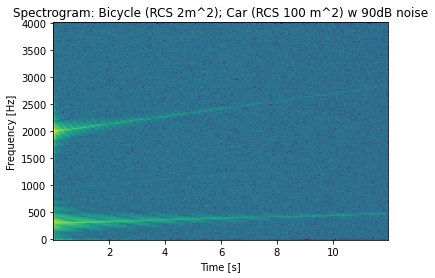

In [22]:
## Plot spectrogram (First 12 seconds, 90dB noise)
ftest, ttest, Sxx = signal.spectrogram(S90[:12*f_sample], f_sample, nperseg=256*2)
plt.pcolormesh(ttest, ftest, Sxx, shading='auto', norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()))
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2) w 90dB noise")
plt.show()

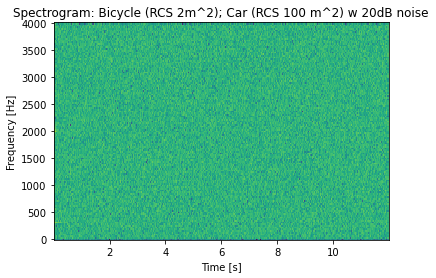

In [225]:
## Plot spectrogram (First 12 seconds, 20dB noise)
ftest, ttest, Sxx = signal.spectrogram(S20[:12*f_sample], f_sample)
plt.pcolormesh(ttest, ftest, Sxx, shading='auto', norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()))
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2) w 20dB noise")
plt.show()

<b>c)</b> Generate signal and spectrograms with using Swerling 1 model for RCS<br>
<b>d)</b> Write signals as .WAV files

In [166]:
# Add in Swerling case
# Generate RCS model vs t, plug that into function with kinematics to generate signal 
s1b = rng.exponential(2,15)          ## cross section samples for bicycle, rcs average is 2m^2
s1c = rng.exponential(100,15)        ## cross section samples for car, rcs average is 100m^2
s1b_cs = np.zeros(t_max*f_sample)
s1c_cs = np.zeros(t_max*f_sample)
cs_index = -1                        ## index to cross section samples
for i in range(t.size):
    if i%f_sample == 0:
        cs_index += 1

    s1b_cs[i] = s1b[cs_index]
    s1c_cs[i] = s1c[cs_index]
print("Bicycle: {}".format(s1b))
print("Car: {}".format(s1c))

Bicycle: [1.86579836 2.15533709 2.45545164 1.56144821 2.06132115 3.33493397
 0.57596675 1.89906332 1.77393699 3.69667573 0.38372049 2.57991833
 0.49367036 1.41511325 4.0508162 ]
Car: [ 71.57321455   5.69511639  79.25281521 152.65301104  95.15875787
 199.99845556  36.23486496   8.99828006  44.17062474  66.48427347
 217.63087312 154.40630226  77.77661342 268.99561454 514.51275305]


In [167]:
# Generate Swerling I model signal

Ab_sw1=get_sig(s1b_cs, xb)
fb_sw1=get_doppler(vb)
Sb_sw1=Ab_sw1*np.cos(2*np.pi*fb_sw1*t)

# Calculate amplitude and frequency of signal vs time
Ac_sw1=get_sig(s1c_cs, xb)
fc_sw1=get_doppler(vc)
Sc_sw1=Ac_sw1*np.cos(2*np.pi*fc_sw1*t)

# This is the full signal
S_sw1=Sb_sw1+Sc_sw1

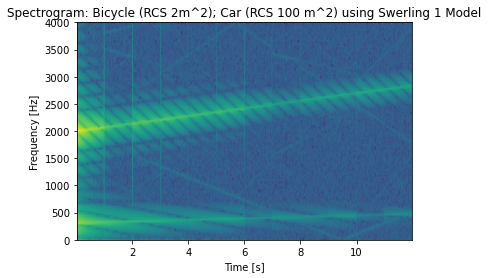

In [178]:
## Plot spectrogram (First 12 seconds, 20dB noise) of Swertling I model
ftest, ttest, Sxx = signal.spectrogram(get_norm(S_sw1)[:12*f_sample], f_sample, nperseg=256)
plt.pcolormesh(ttest, ftest, Sxx, shading='gouraud', norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()))
plt.xlabel("Time [s]"), plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram: Bicycle (RCS 2m^2); Car (RCS 100 m^2) using Swerling 1 Model")
plt.show()

In [169]:
## Generate WAV file for Swerling 1 model
wavfile.write("S.Swerling1.wav", f_sample, get_norm(S_sw1))